## FIRST PREDICTION MODEL: LINEAR REGRESSION

necessary steps: 
* Step 1: data cleaning and NAs removal or imputing (already done)
* Step 2: encoding of categorical variables (or dummies) and standardization of numerical variables (pay attention to exclude the target variable ('Trip_Price')
* Step 3: split the dataset into train and test 
* Step 4: fit the model on the training set and evaluate its performance on the test set
* Step 5: evalaute some techniques to improve the performance of the linear regression

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import numpy as np

In [2]:
path = 'data_clean.csv'
df_original = pd.read_csv(path)

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       983 non-null    float64
 1   Time_of_Day            983 non-null    object 
 2   Day_of_Week            983 non-null    object 
 3   Passenger_Count        983 non-null    float64
 4   Traffic_Conditions     983 non-null    object 
 5   Weather                983 non-null    object 
 6   Base_Fare              983 non-null    float64
 7   Per_Km_Rate            983 non-null    float64
 8   Per_Minute_Rate        983 non-null    float64
 9   Trip_Duration_Minutes  983 non-null    float64
 10  Trip_Price             983 non-null    float64
 11  Trip_Distance_km_log   983 non-null    float64
 12  Trip_Price_log         983 non-null    float64
dtypes: float64(9), object(4)
memory usage: 100.0+ KB


# STEP 1: data cleaning and NAs removal or imputing (already done)

In [4]:
# Create a copy to avoid modifying the original dataframe
df_linear_model = df_original.copy()

# Drop the original non-log transformed columns
#df_linear_model = df_linear_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Drop the original log transformed columns (because the log trasformation might interfere with outliers identification)
df_linear_model = df_linear_model.drop(['Trip_Distance_km_log', 'Trip_Price_log'], axis=1)

#Logarithmic transformation modifies the distribution shape (making it more symmetric)
#while standardization maintains the same distribution (same shape) but changes the scale.
#you can still identify outliers after standardization, as this does not change the distribution shape and maintains the distribution of values.

## it's better to first estimate a "raw" model without standardization, then remove all outliers, then standardize
#  if there's still a lot of variability, consider also logarithmic transformation


## STEP 2: identify categorical columns and introduce dummies (first raw model without standardization)

In [5]:
# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_linear_model[column], prefix=column, drop_first=True)
    df_linear_model = pd.concat([df_linear_model, dummies], axis=1)
    df_linear_model = df_linear_model.drop(column, axis=1)

df_linear_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           983 non-null    float64
 1   Passenger_Count            983 non-null    float64
 2   Base_Fare                  983 non-null    float64
 3   Per_Km_Rate                983 non-null    float64
 4   Per_Minute_Rate            983 non-null    float64
 5   Trip_Duration_Minutes      983 non-null    float64
 6   Trip_Price                 983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    bool   
 8   Time_of_Day_Morning        983 non-null    bool   
 9   Time_of_Day_Night          983 non-null    bool   
 10  Day_of_Week_Weekend        983 non-null    bool   
 11  Traffic_Conditions_Low     983 non-null    bool   
 12  Traffic_Conditions_Medium  983 non-null    bool   
 13  Weather_Rain               983 non-null    bool   

In [6]:
df_linear_model.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,19.35000,3.0,3.560000,0.80,0.32,53.82,36.2600,False,True,False,False,True,False,False,False
1,47.59000,1.0,3.500522,0.62,0.43,40.57,29.5058,False,False,False,False,False,False,False,False
2,36.87000,1.0,2.700000,1.21,0.15,37.27,52.9000,True,False,False,True,False,False,False,False
3,30.33000,4.0,3.480000,0.51,0.15,116.81,36.4700,True,False,False,False,True,False,False,False
4,8.26455,3.0,2.930000,0.63,0.32,22.64,15.6200,True,False,False,False,False,False,False,False


## STEP 3: split features and target variables and split dataset in training and test

In [7]:
# split the variables into predictors X (features) e y (target)
#X = df_linear_model.drop('Trip_Price_log', axis=1)
#y = df_linear_model['Trip_Price_log']

X = df_linear_model.drop('Trip_Price', axis=1)
y = df_linear_model['Trip_Price']
# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## STEP 4: train the model on the training set and test its performance on the test set 
## MODEL DONE USING SKLEARN LinearRegression

In [8]:
# Creare il modello di regressione lineare e allenarlo sui dati di training
model = LinearRegression()
model.fit(X_train, y_train)

# try predictions with the test set
y_pred = model.predict(X_test)

# evaluate the model performance by comparing true y_test with y_pred
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R²

print(f'Mean Squared Error (MSE): {mse}')
print(f'R²: {r2}')

Mean Squared Error (MSE): 480.12812029602003
R²: 0.79138154109125


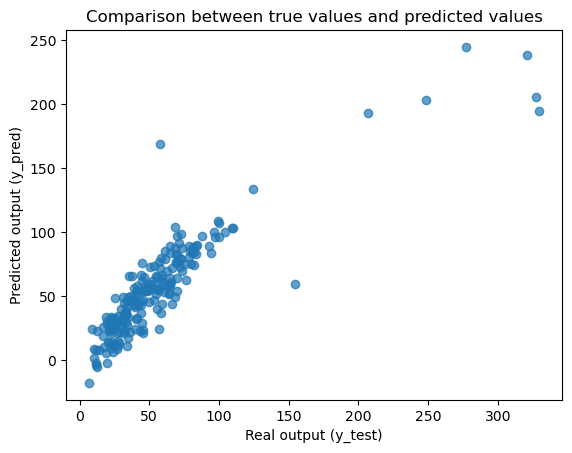

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Real output (y_test)')
plt.ylabel('Predicted output (y_pred)')
plt.title('Comparison between true values and predicted values')
plt.show()


In [10]:
# Calcolare i residui sui dati di test
residuals = y_test - y_pred

# Calcolare la varianza residua
residual_variance = np.sum(residuals**2) / (X_test.shape[0] - X_test.shape[1] - 1)

X_test_matrix = np.hstack([np.ones((X_test.shape[0], 1)), X_test.values])  # Aggiungi l'intercetta
XtX_inv = np.linalg.inv(X_test_matrix.T @ X_test_matrix)
stderr = np.sqrt(residual_variance * np.diag(XtX_inv))

# Calcolare i t-statistics e i p-values per i coefficienti
t_stats = model.coef_ / stderr[1:]  # Ignora l'intercetta
df = X_test.shape[0] - X_test.shape[1] - 1
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=df)) for t in t_stats]

# Creare un DataFrame con i risultati
results = pd.DataFrame({
    'Coefficient': np.hstack([model.intercept_, model.coef_]),  # Include l'intercetta
    'Standard Error': stderr,
    'T-statistic': np.hstack([model.intercept_ / stderr[0], t_stats]),
    'P-value': [2 * (1 - stats.t.cdf(np.abs(model.intercept_ / stderr[0]), df=df))] + p_values
}, index=['Intercept'] + list(X_test.columns))

print("\nRegressione Lineare - Risultati dei Coefficienti:")
print(results)

# Visualizzare le metriche di performance
print(f'\nMean Squared Error (MSE) sui dati di test: {mse}')
print(f'R² sui dati di test: {r2}')



Regressione Lineare - Risultati dei Coefficienti:
                           Coefficient  Standard Error  T-statistic  \
Intercept                   -37.157024       10.418380    -3.566488   
Trip_Distance_km              1.649128        0.073606    22.404893   
Passenger_Count               3.151106        1.641905     1.919176   
Base_Fare                    -0.880013        1.993027    -0.441546   
Per_Km_Rate                  22.315471        3.690391     6.046912   
Per_Minute_Rate              17.700892        8.782570     2.015457   
Trip_Duration_Minutes         0.205338        0.050183     4.091785   
Time_of_Day_Evening          -0.528013        4.902221    -0.107709   
Time_of_Day_Morning           1.370462        3.868092     0.354299   
Time_of_Day_Night             1.694543        6.291155     0.269353   
Day_of_Week_Weekend           2.458593        3.659597     0.671821   
Traffic_Conditions_Low       -2.785722        4.612679    -0.603927   
Traffic_Conditions_Medium 

In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f'R² medio dalla cross-validation: {np.mean(cv_scores)}')


R² medio dalla cross-validation: 0.7457360331202605


In [12]:
print(X_train.dtypes)


Trip_Distance_km             float64
Passenger_Count              float64
Base_Fare                    float64
Per_Km_Rate                  float64
Per_Minute_Rate              float64
Trip_Duration_Minutes        float64
Time_of_Day_Evening            int32
Time_of_Day_Morning            int32
Time_of_Day_Night              int32
Day_of_Week_Weekend            int32
Traffic_Conditions_Low         int32
Traffic_Conditions_Medium      int32
Weather_Rain                   int32
Weather_Snow                   int32
dtype: object


## MODEL DONE WITH STATS library SM.OLS

In [13]:
import statsmodels.api as sm
# split the variables into predictors X (features) e y (target)
#X = df_linear_model.drop('Trip_Price_log', axis=1)
#y = df_linear_model['Trip_Price_log']
X = df_linear_model.drop('Trip_Price', axis=1)
y = df_linear_model['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())



Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     188.8
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          7.38e-238
Time:                        02:26:53   Log-Likelihood:                -3425.0
No. Observations:                 786   AIC:                             6880.
Df Residuals:                     771   BIC:                             6950.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

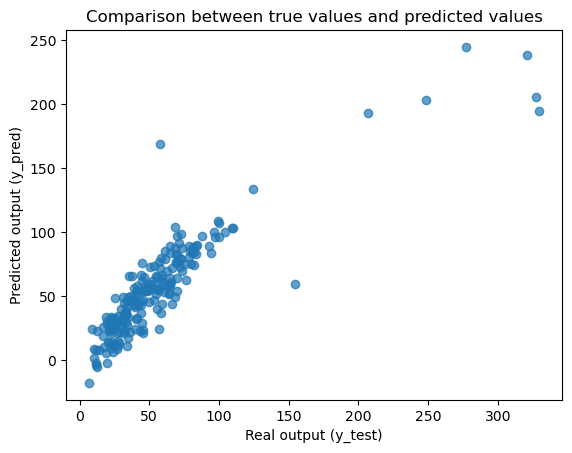

In [14]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Real output (y_test)')
plt.ylabel('Predicted output (y_pred)')
plt.title('Comparison between true values and predicted values')
plt.show()


In [15]:
X_train_sm = X_train_sm.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [16]:
# Calcola le misure diagnostiche
influence = linear_model.get_influence()

# Residui standardizzati
standardized_residuals = influence.resid_studentized_internal

# Leverage (hat values)
leverage = influence.hat_matrix_diag

# Cook's Distance
cooks_distance = influence.cooks_distance[0]

# DFFITS
dffits = influence.dffits[0]

# Crea un DataFrame con tutte le metriche diagnostiche
diagnostics = pd.DataFrame({
    'Standardized_Residuals': standardized_residuals,
    'Leverage': leverage,
    'Cooks_Distance': cooks_distance,
    'DFFITS': dffits
})

# Visualizza i primi risultati diagnostici
print(diagnostics.head())

   Standardized_Residuals  Leverage  Cooks_Distance    DFFITS
0               -1.526958  0.023372        0.003720 -0.236419
1                0.025231  0.032284        0.000001  0.004606
2               -0.212258  0.009810        0.000030 -0.021114
3                1.104470  0.031046        0.002606  0.197727
4                1.090904  0.015096        0.001216  0.135076


In [17]:
# threshold
threshold_std_resid = 3
threshold_leverage = 2 * (X_train_sm.shape[1] + 1) / X_train_sm.shape[0]
threshold_cooks = 4 / X_train_sm.shape[0]
threshold_dffits = 2 * np.sqrt((X_train_sm.shape[1] + 1) / X_train_sm.shape[0])

# Identificare outlier
outliers = diagnostics[
    (diagnostics['Standardized_Residuals'].abs() > threshold_std_resid) |
    (diagnostics['Leverage'] > threshold_leverage) |
    (diagnostics['Cooks_Distance'] > threshold_cooks) |
    (diagnostics['DFFITS'].abs() > threshold_dffits)]

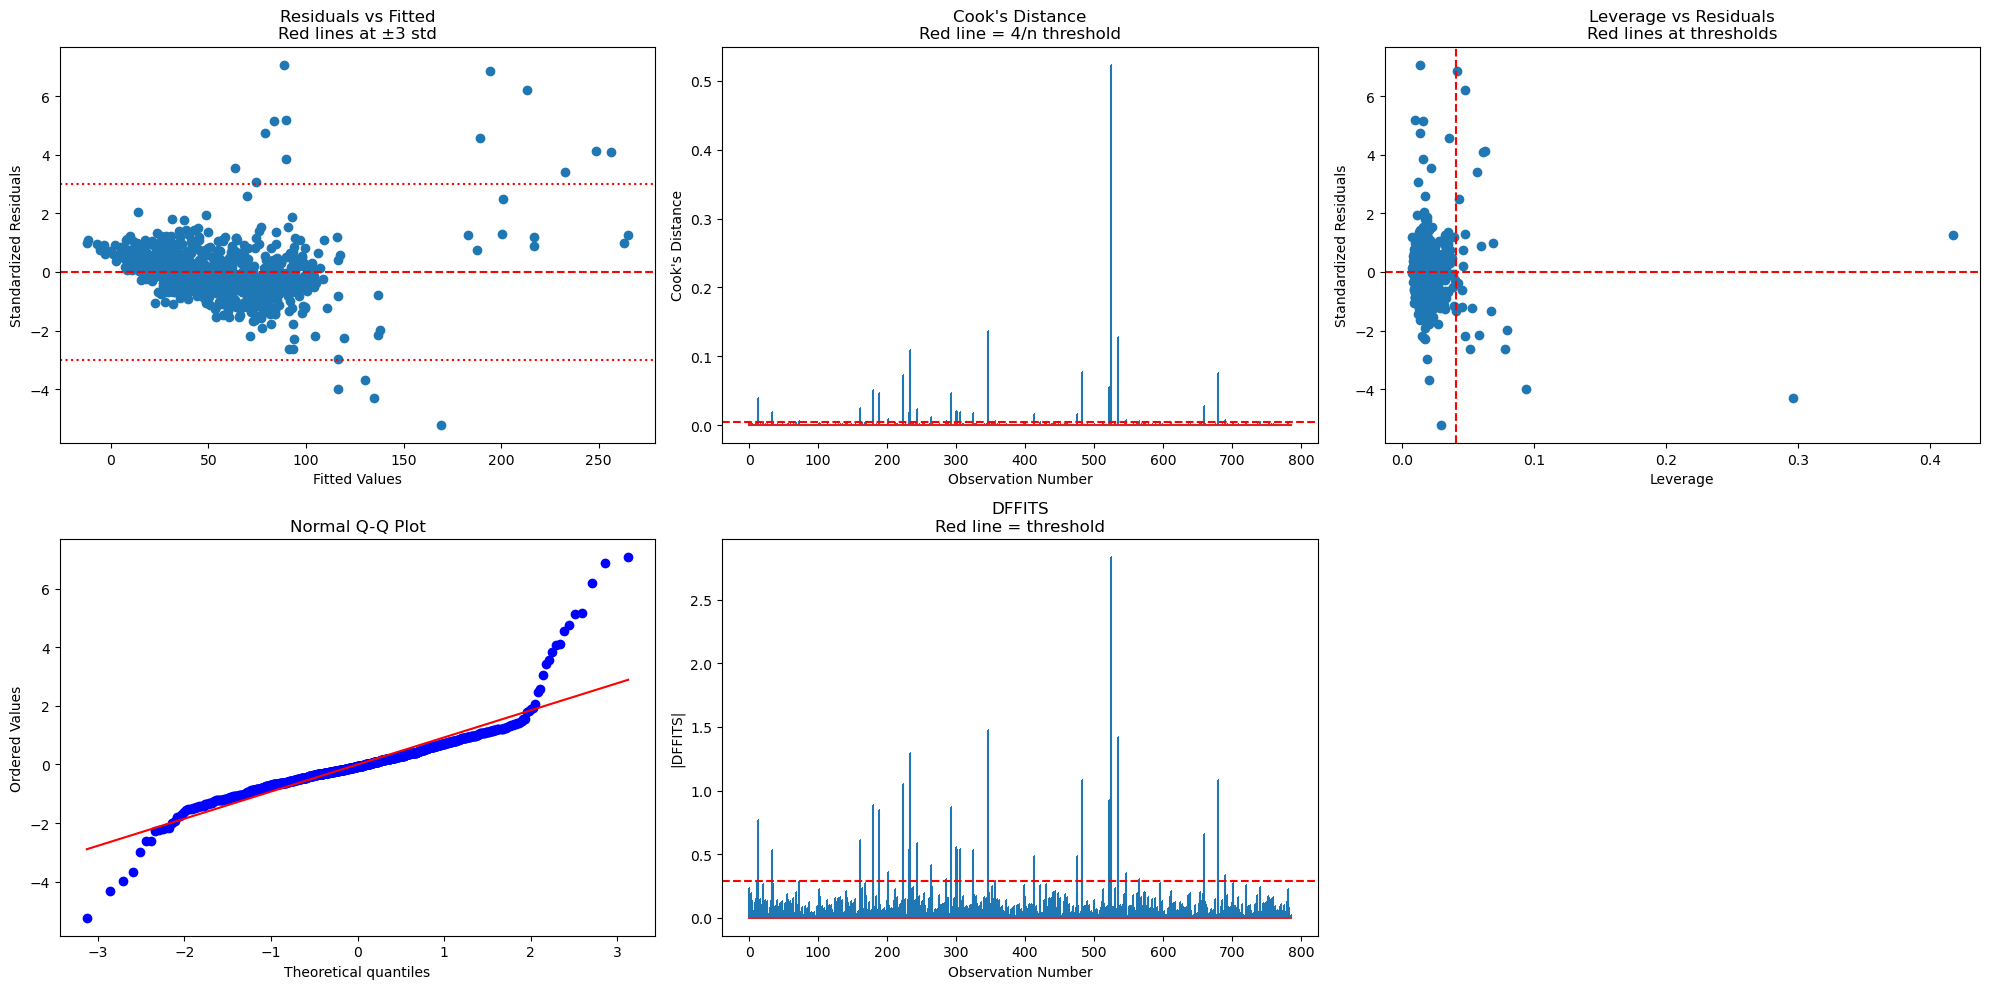

In [18]:
# Create diagnostic plots
fig = plt.figure(figsize=(20, 10))

# 1. Standardized Residuals vs Fitted Values
plt.subplot(231)
plt.scatter(linear_model.fittedvalues, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='r', linestyle=':')
plt.axhline(y=-3, color='r', linestyle=':')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Fitted\nRed lines at ±3 std')

# 2. Cook's Distance Plot
plt.subplot(232)
plt.stem(range(len(cooks_distance)), cooks_distance, markerfmt=',')
plt.axhline(y=threshold_cooks, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance\nRed line = 4/n threshold")

# 3. Leverage vs Standardized Residuals
plt.subplot(233)
plt.scatter(leverage, standardized_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=threshold_leverage, color='r', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs Residuals\nRed lines at thresholds')

# 4. QQ Plot
plt.subplot(234)
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# 5. DFFITS Plot
plt.subplot(235)
plt.stem(range(len(dffits)), np.abs(dffits), markerfmt=',')
plt.axhline(y=threshold_dffits, color='r', linestyle='--')
plt.xlabel('Observation Number')
plt.ylabel('|DFFITS|')
plt.title('DFFITS\nRed line = threshold')

plt.tight_layout()
plt.show()


In [19]:
# observations with high leverage
high_leverage_points = diagnostics[diagnostics['Leverage'] > (2 * X_train_sm.shape[1] / X_train_sm.shape[0])]

# observations with high Cook's Distance
high_cooks_distance_points = diagnostics[diagnostics['Cooks_Distance'] > 1]

# observations with high DFFITS
threshold_dffits = 2 * ((X_train_sm.shape[1] / X_train_sm.shape[0]) ** 0.5)
high_dffits_points = diagnostics[abs(diagnostics['DFFITS']) > threshold_dffits]

# Show influential points
print("Punti con alto leverage:\n", high_leverage_points)
print("\nPunti con alta Cook's Distance:\n", high_cooks_distance_points)
print("\nPunti con alto DFFITS:\n", high_dffits_points)


Punti con alto leverage:
      Standardized_Residuals  Leverage  Cooks_Distance    DFFITS
13                -2.628266  0.078164        0.039048 -0.768277
20                -1.202413  0.045626        0.004608 -0.262983
72                -1.227385  0.053194        0.005643 -0.291021
132               -0.622724  0.045106        0.001221 -0.135289
161               -2.619152  0.051128        0.024642 -0.610302
188                3.416903  0.056787        0.046861  0.844276
201               -1.327725  0.067371        0.008490 -0.357031
223                4.087895  0.061089        0.072485  1.053529
231               -2.160135  0.058056        0.019173 -0.537561
233               -3.984490  0.093805        0.109561 -1.294525
236               -1.170250  0.039022        0.003707 -0.235876
243               -1.989065  0.079598        0.022810 -0.586068
301                2.492251  0.043492        0.018828  0.533244
346                6.877640  0.041421        0.136265  1.474701
357           

In [20]:
# Delete outliers from the training set
print(len(outliers))

print(outliers.index)

X_train_sm = X_train_sm.drop(index = outliers.index.tolist())
y_train = y_train.drop(index = outliers.index.tolist())

40
Index([ 12,  13,  20,  33,  72, 132, 161, 179, 188, 201, 223, 231, 233, 243,
       264, 286, 292, 300, 301, 305, 324, 346, 357, 413, 430, 474, 476, 483,
       485, 522, 525, 535, 547, 565, 596, 660, 680, 690, 752, 781],
      dtype='int64')


In [21]:
# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     267.0
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          4.70e-276
Time:                        02:26:57   Log-Likelihood:                -2818.3
No. Observations:                 746   AIC:                             5667.
Df Residuals:                     731   BIC:                             5736.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

In [22]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error: 565.3218
Root Mean Squared Error: 23.7765
R-squared: 0.8364
Mean Absolute Percentage Error: 73040036873940930490622395047519191040.00%


## THIS TIME WE FIT ANOTHER LR MODEL WITHOUT OUTLIERS AND WITH STANDARDIZATION OF QUANTITATIVE VARIABLES

In [24]:
#Scale numerical features only (not using log)
numerical_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

target_column = ['Trip Price']

#set the scaler 
scaler = StandardScaler()
df_model_scaled = df_linear_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_linear_model[numerical_columns])

X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)
X_train_sm = X_train_sm.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Delete outliers from the training set (using the same indexes of outliers identified before)
X_train_sm = X_train_sm.drop(index = outliers.index.tolist())
y_train = y_train.drop(index = outliers.index.tolist())

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())



Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     267.0
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          4.70e-276
Time:                        02:27:16   Log-Likelihood:                -38.375
No. Observations:                 746   AIC:                             106.8
Df Residuals:                     731   BIC:                             176.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

In [25]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")



Model Performance Metrics:
Mean Squared Error: 0.3277
Root Mean Squared Error: 0.5725
R-squared: 0.8364
Mean Absolute Percentage Error: 25.56%


In [26]:
# Get residuals and fitted values
residuals = linear_model.resid
fitted_values = linear_model.fittedvalues

Text(0.5, 1.0, 'Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

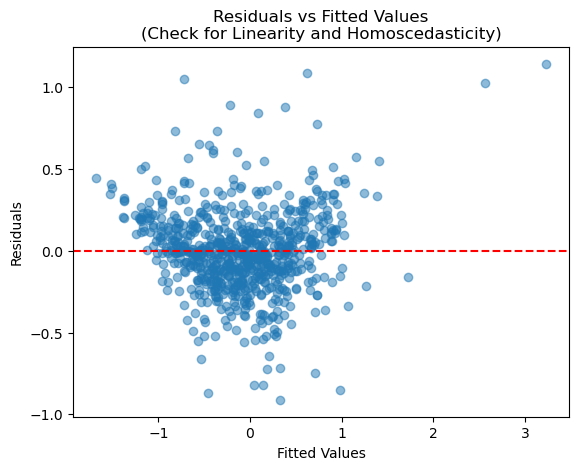

In [27]:
# 1. Residuals vs Fitted Values
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

Text(0.5, 1.0, 'Q-Q Plot\n(Check for Normality of Residuals)')

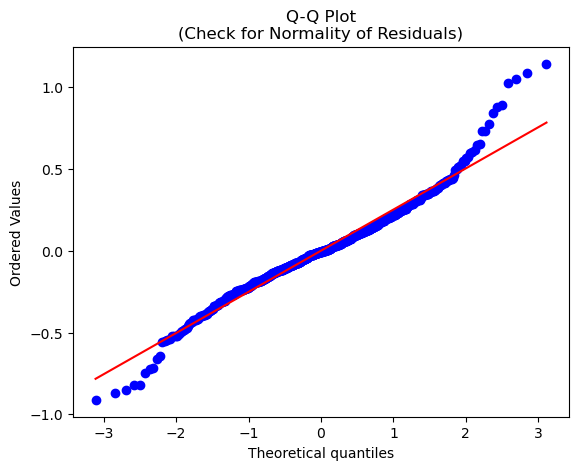

In [28]:
# 2. Q-Q Plot for Normality
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot\n(Check for Normality of Residuals)')

Text(0.5, 1.0, 'Histogram of Residuals\n(Check for Normality)')

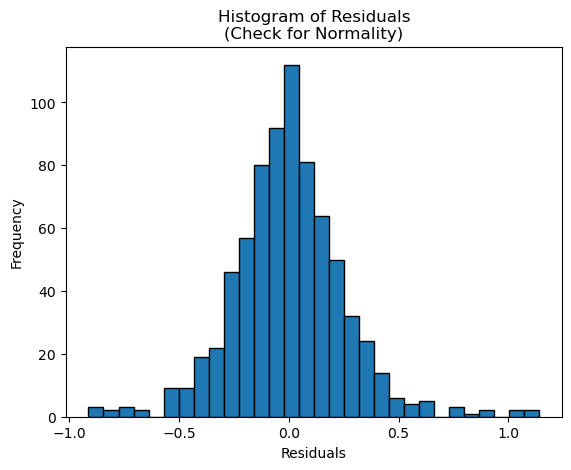

In [29]:
# 3. Residuals Histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals\n(Check for Normality)')

Text(0.5, 1.0, 'Correlation Heatmap\n(Check for Multicollinearity)')

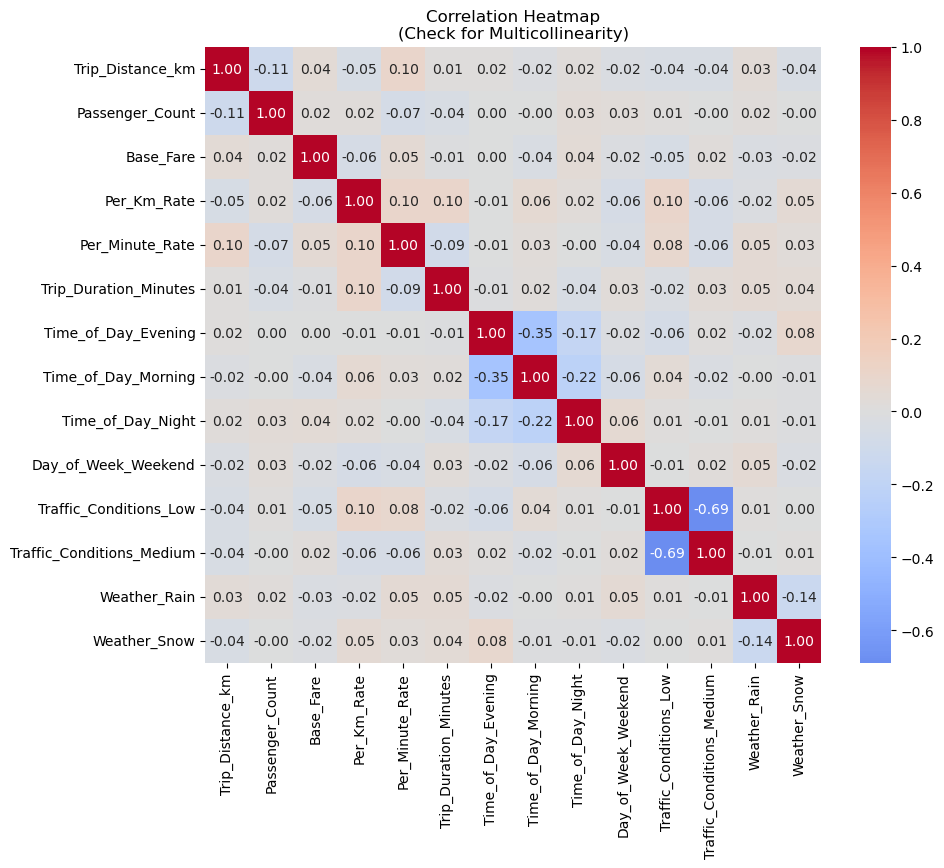

In [30]:
# 4. Correlation Heatmap
import seaborn as sns
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Correlation Heatmap\n(Check for Multicollinearity)')

In [31]:
# Split tha data (not standardized data) (only for unstandardize coefficients)
X_un = df_linear_model.drop('Trip_Price', axis=1)
y_un = df_linear_model['Trip_Price']
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X_un, y_un, test_size=0.2, random_state=42)

X_train_un = X_train_un.reset_index(drop=True)
X_train_un = X_train_un.drop(index = outliers.index.tolist())

# Assuming X_train_un is your original (non-standardized) design matrix
# and X_train_sm is the standardized design matrix used in the model

# Get the original column names (excluding any dummy variables)
original_columns = [col for col in X_train_un.columns if col in numerical_columns]

# Get standard deviations of original numerical columns
std_X = X_train_un[original_columns].std()

# Get standardized coefficients (excluding intercept)
beta_standardized = linear_model.params[1:len(original_columns)+1]

# Rescale coefficients
beta_original = beta_standardized * (std_X / np.std(y_train_un))

# Reconstruct with intercept
beta_original_with_intercept = pd.Series(
    [linear_model.params[0]] + list(beta_original), 
    index=['Intercept'] + list(original_columns)
)

print(beta_original_with_intercept)

Intercept               -0.060270
Trip_Distance_km         0.234996
Passenger_Count          0.001404
Base_Fare                0.000040
Per_Km_Rate              0.002919
Per_Minute_Rate          0.000879
Trip_Duration_Minutes    0.182167
dtype: float64


C:\Users\diego\AppData\Local\Temp\ipykernel_17216\3254119913.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [linear_model.params[0]] + list(beta_original),


### BEST SUBSET SELECTION

In [32]:
from itertools import combinations
import statsmodels.api as sm
import numpy as np

# Rimuovi la colonna const (se esiste)
if 'const' in X_train_sm.columns:
    X_train_sm = X_train_sm.drop('const', axis=1)

# Assicurati che X_train_sm e y_train abbiano gli stessi indici
X_train_sm = X_train_sm.loc[y_train.index]

n_features = X_train_sm.shape[1]
best_models = {}

for k in range(1, n_features + 1):
    best_score = -np.inf
    best_combo = None
    best_model = None

    # Get all possible combinations of k features
    for combo in combinations(range(n_features), k):
        # Get the features for this combination
        X_subset = X_train_sm.iloc[:, list(combo)]

        # Add constant
        X_subset = sm.add_constant(X_subset)

        # Assicurati che gli indici siano allineati
        X_subset = X_subset.loc[y_train.index]

        # Fit model
        model = sm.OLS(y_train, X_subset).fit()

        # Calculate adjusted R-squared
        score = model.rsquared_adj

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    # Store best model for this number of features
    best_models[k] = {
        'features': [X_train_sm.columns[i] for i in best_combo],
        'model': best_model,
        'adj_r2': best_score,
        'aic': best_model.aic,
        'bic': best_model.bic
    }

    print(f"\nBest model with {k} features:")
    print(f"Features: {best_models[k]['features']}")
    print(f"Adjusted R-squared: {best_score:.4f}")
    print(f"AIC: {best_model.aic:.4f}")
    print(f"BIC: {best_model.bic:.4f}")



Best model with 1 features:
Features: ['Trip_Distance_km']
Adjusted R-squared: 0.5056
AIC: 904.9973
BIC: 914.2268

Best model with 2 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate']
Adjusted R-squared: 0.6909
AIC: 555.5506
BIC: 569.3947

Best model with 3 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7806
AIC: 300.7509
BIC: 319.2098

Best model with 4 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.8271
AIC: 124.1919
BIC: 147.2656

Best model with 5 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.8337
AIC: 96.2099
BIC: 123.8983

Best model with 6 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Time_of_Day_Morning']
Adjusted R-squared: 0.8342
AIC: 94.8541
BIC: 127.1571

Best model with 7 

In [33]:
#X_train_sm.drop('const', axis=1)

X_train_sm = X_train_sm.loc[y_train.index]

n_features = X_train_sm.shape[1]

best_models = {}

from itertools import combinations

for k in range(1, n_features + 1):
    best_score = -np.inf
    best_combo = None
    best_model = None

    # Get all possible combinations of k features
    for combo in combinations(range(n_features), k):
        # Get the features for this combination
        X_subset = X_train_sm.iloc[:, list(combo)]

        # Add constant
        X_subset = sm.add_constant(X_subset)

        # Fit model
        model = sm.OLS(y_train, X_subset).fit()

        # Calculate adjusted R-squared
        score = model.rsquared_adj

        if score > best_score:
            best_score = score
            best_combo = combo
            best_model = model

    # Store best model for this number of features
    best_models[k] = {
        'features': [X_train_sm.columns[i] for i in best_combo],
        'model': best_model,
        'adj_r2': best_score,
        'aic': best_model.aic,
        'bic': best_model.bic
    }

    print(f"\nBest model with {k} features:")
    print(f"Features: {best_models[k]['features']}")
    print(f"Adjusted R-squared: {best_score:.4f}")
    print(f"AIC: {best_model.aic:.4f}")
    print(f"BIC: {best_model.bic:.4f}")


Best model with 1 features:
Features: ['Trip_Distance_km']
Adjusted R-squared: 0.5056
AIC: 904.9973
BIC: 914.2268

Best model with 2 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate']
Adjusted R-squared: 0.6909
AIC: 555.5506
BIC: 569.3947

Best model with 3 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.7806
AIC: 300.7509
BIC: 319.2098

Best model with 4 features:
Features: ['Trip_Distance_km', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.8271
AIC: 124.1919
BIC: 147.2656

Best model with 5 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R-squared: 0.8337
AIC: 96.2099
BIC: 123.8983

Best model with 6 features:
Features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Time_of_Day_Morning']
Adjusted R-squared: 0.8342
AIC: 94.8541
BIC: 127.1571

Best model with 7 

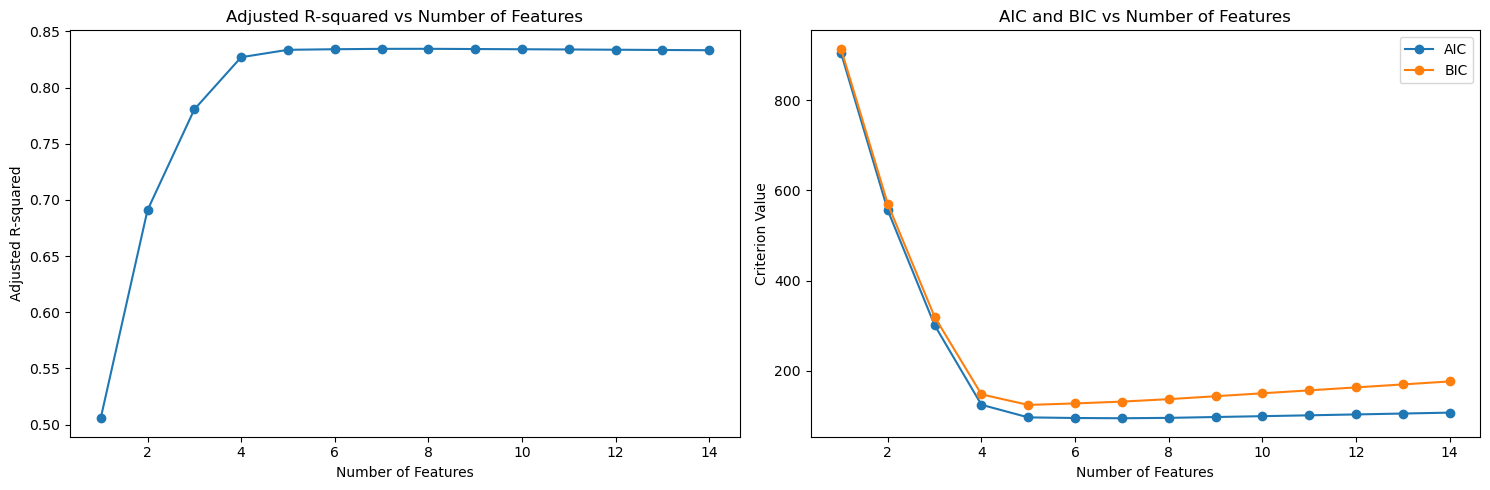

In [38]:
n_features = list(best_models.keys())
adj_r2 = [model['adj_r2'] for model in best_models.values()]
aic = [model['aic'] for model in best_models.values()]
bic = [model['bic'] for model in best_models.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Adjusted R-squared
ax1.plot(n_features, adj_r2, marker='o')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Adjusted R-squared')
ax1.set_title('Adjusted R-squared vs Number of Features')

# Plot AIC and BIC
ax2.plot(n_features, aic, marker='o', label='AIC')
ax2.plot(n_features, bic, marker='o', label='BIC')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Criterion Value')
ax2.set_title('AIC and BIC vs Number of Features')
ax2.legend()

plt.tight_layout()
plt.show()

In [39]:
print(best_models[4]['model'].summary())

                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     892.0
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          1.67e-281
Time:                        02:33:29   Log-Likelihood:                -57.096
No. Observations:                 746   AIC:                             124.2
Df Residuals:                     741   BIC:                             147.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.02

In [40]:
# Best model chosen based on BIC
best_bic = float('inf')
best_model_key = None

for k, model_info in best_models.items():
    if model_info['bic'] < best_bic:
        best_bic = model_info['bic']
        best_model_key = k
    
best_model_info = best_models[best_model_key]
best_model = best_model_info['model']
selected_features = best_model_info['features']

print("\n=== Best Model based on BIC ===")
print(f"Number of features: {best_model_key}")
print(f"Selected features: {selected_features}")
print(f"Adjusted R²: {best_model_info['adj_r2']:.4f}")
print(f"AIC: {best_model_info['aic']:.4f}")
print(f"BIC: {best_model_info['bic']:.4f}")

# Testing the model performance
X_test_subset = X_test[selected_features]  #select the same features
X_test_subset = sm.add_constant(X_test_subset)  # add intercept
y_pred = best_model.predict(X_test_subset)

# Compute performance on test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Performance on Test Set ===")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# print coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': best_model.params.values
})

# order coefficients
#coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("\n=== Coefficienti of best model based on BIC  ===")
print(coef_df)



=== Best Model based on BIC ===
Number of features: 5
Selected features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
Adjusted R²: 0.8337
AIC: 96.2099
BIC: 123.8983

=== Performance on Test Set ===
Mean Squared Error: 0.3261
Root Mean Squared Error: 0.5711
R-squared: 0.7556

=== Coefficienti of best model based on BIC  ===
                 Feature  Coefficient
0              Intercept    -0.026771
1       Trip_Distance_km     0.624482
2        Passenger_Count     0.051386
3            Per_Km_Rate     0.265697
4        Per_Minute_Rate     0.275236
5  Trip_Duration_Minutes     0.221728


In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

#Find the best model based on Adjusted R²
best_model_key = max(best_models, key=lambda k: best_models[k]['adj_r2'])
best_model_info = best_models[best_model_key]
best_model = best_model_info['model']
selected_features = best_model_info['features']

print("\n=== Best model based on Adjusted R2 ===")
print(f"Number of features: {best_model_key}")
print(f"Selected features: {selected_features}")
print(f"Adjusted R²: {best_model_info['adj_r2']:.4f}")
print(f"AIC: {best_model_info['aic']:.4f}")
print(f"BIC: {best_model_info['bic']:.4f}")

# Testing the model
X_test_subset = X_test[selected_features]  # Seleziona le stesse feature nel test set
X_test_subset = sm.add_constant(X_test_subset)  # Aggiunge l'intercetta
y_pred = best_model.predict(X_test_subset)

# Compute performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Performance on Test Set ===")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

#Print coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features,
    'Coefficient': best_model.params.values
})

# Ordina i coefficienti in ordine decrescente (opzionale)
#coef_df = coef_df.sort_values(by='Coefficient', ascending=True)

print("\n=== Coefficienti del Modello Migliore ===")
print(coef_df)



=== Best model based on Adjusted R2 ===
Number of features: 8
Selected features: ['Trip_Distance_km', 'Passenger_Count', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Time_of_Day_Morning', 'Day_of_Week_Weekend', 'Weather_Snow']
Adjusted R²: 0.8346
AIC: 95.1296
BIC: 136.6621

=== Performance on Test Set ===
Mean Squared Error: 0.3275
Root Mean Squared Error: 0.5722
R-squared: 0.7546

=== Coefficienti del Modello Migliore ===
                 Feature  Coefficient
0              Intercept    -0.048844
1       Trip_Distance_km     0.626301
2        Passenger_Count     0.051117
3            Per_Km_Rate     0.265171
4        Per_Minute_Rate     0.278288
5  Trip_Duration_Minutes     0.220381
6    Time_of_Day_Morning     0.038774
7    Day_of_Week_Weekend     0.022105
8           Weather_Snow     0.067834


### ELASTIC NET REGRESSION

In [42]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

#remove outliers from a copy of the oroginal dataframe
df_model_cleaned = df_linear_model.copy()

# Rimuovi gli outliers dal dataset originale (o dalla sua copia)
df_model_cleaned = df_model_cleaned.drop(index=outliers.index.tolist())

df_model_cleaned.shape

df_model_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           943 non-null    float64
 1   Passenger_Count            943 non-null    float64
 2   Base_Fare                  943 non-null    float64
 3   Per_Km_Rate                943 non-null    float64
 4   Per_Minute_Rate            943 non-null    float64
 5   Trip_Duration_Minutes      943 non-null    float64
 6   Trip_Price                 943 non-null    float64
 7   Time_of_Day_Evening        943 non-null    bool   
 8   Time_of_Day_Morning        943 non-null    bool   
 9   Time_of_Day_Night          943 non-null    bool   
 10  Day_of_Week_Weekend        943 non-null    bool   
 11  Traffic_Conditions_Low     943 non-null    bool   
 12  Traffic_Conditions_Medium  943 non-null    bool   
 13  Weather_Rain               943 non-null    bool   
 14 

In [43]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

#prepare the data like before
#categorical columns are already dummies
#Scale numerical features only (not using log)
numerical_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']

#set the scaler 
scaler = StandardScaler()
df_model_scaled = df_linear_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_linear_model[numerical_columns])

X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split the  dataset (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Delete outliers from the training set (using the same indexes of outliers identified before)
X_train = X_train.drop(index = outliers.index.tolist())
y_train = y_train.drop(index = outliers.index.tolist())

# setup alpha e l1_ratio
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Train the model 
elastic_net_model.fit(X_train, y_train)

# Make predictions
y_pred = elastic_net_model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = elastic_net_model.score(X_test, y_test)  # R^2 score
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Percentuale errore assoluto medio

# Stampa i risultati
print("\nModel Performance Metrics for ElasticNet:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Model Performance Metrics for ElasticNet:
Mean Squared Error (MSE): 1.3406
Root Mean Squared Error (RMSE): 1.1578
R-squared: -0.0048
Mean Absolute Percentage Error (MAPE): 139.54%


In [44]:
X_train

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,-0.423681,-1.384620,0.917295,-0.363794,-0.688543,3.248733,0,0,0,0,0,1,0,0
1,-0.099375,-0.459972,-0.296720,1.322367,0.070833,0.192441,0,1,0,1,0,1,0,1
2,0.122779,0.464675,1.318038,-0.279486,0.030866,-0.679627,0,1,0,0,1,0,0,0
3,-0.692944,0.464675,1.318038,-0.153024,0.510471,1.064787,0,0,0,0,0,1,0,1
4,-1.194774,-1.384620,0.339754,-1.080412,-0.129003,-1.508565,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,-1.280561,-0.459972,1.141240,-1.312259,-0.608609,-0.724705,0,1,0,0,0,0,0,0
782,0.285428,1.389323,-1.251432,-0.131947,0.430537,-0.904740,0,0,1,0,0,1,0,0
783,-0.914602,0.464675,-1.628602,-1.312259,-0.208937,-0.853262,0,0,0,0,0,1,1,0
784,-0.393432,-0.459972,1.341612,-1.417644,-0.630374,1.331082,0,0,0,1,1,0,0,0


In [45]:
coefficients = elastic_net_model.coef_

# Crea un DataFrame per visualizzare i coefficienti con i nomi delle variabili
coeff_df = pd.DataFrame({
    'Feature': X.columns,  # I nomi delle variabili
    'Coefficient': coefficients     # I coefficienti del modello
})

# Ordina i coefficienti in ordine decrescente (opzionale)
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# Mostra il DataFrame
print(coeff_df)

                      Feature  Coefficient
0            Trip_Distance_km          0.0
1             Passenger_Count          0.0
2                   Base_Fare          0.0
3                 Per_Km_Rate          0.0
4             Per_Minute_Rate          0.0
5       Trip_Duration_Minutes          0.0
6         Time_of_Day_Evening         -0.0
7         Time_of_Day_Morning          0.0
8           Time_of_Day_Night          0.0
9         Day_of_Week_Weekend         -0.0
10     Traffic_Conditions_Low          0.0
11  Traffic_Conditions_Medium         -0.0
12               Weather_Rain          0.0
13               Weather_Snow          0.0


#### elastic net with parameters found by cross-validation 

In [46]:
from sklearn.linear_model import ElasticNetCV

# Create and train the ElasticNetCV model with cross-validation
# cv=5 for 5-fold cross-validation
elastic_net_cv = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=np.logspace(-4, 1, 50),
    cv=5,
    random_state=42)

elastic_net_cv.fit(X_train, y_train)

# Coefficients of the final model
intercept = elastic_net_cv.intercept_
coefficients = elastic_net_cv.coef_

# Create a DataFrame to display the coefficients
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Sort the coefficients in descending order (optional)
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# # Print the results of the model
print("\n=== ElasticNet Model Summary ===")
print(f"Best alpha: {elastic_net_cv.alpha_}")
print(f"Best L1 Ratio (Mix Lasso-Ridge): {elastic_net_cv.l1_ratio_}")
print(f"Intercept (β0): {elastic_net_cv.intercept_:.4f}\n")
print("Feature Coefficients:")
print(coeff_df)

# Make predictions on the test set
y_pred = elastic_net_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Make predictions on the test set
y_pred = elastic_net_cv.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (test): {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")



=== ElasticNet Model Summary ===
Best alpha: 0.0021209508879201904
Best L1 Ratio (Mix Lasso-Ridge): 0.95
Intercept (β0): -0.0409

Feature Coefficients:
                      Feature  Coefficient
0            Trip_Distance_km     0.621277
4             Per_Minute_Rate     0.269294
3                 Per_Km_Rate     0.263358
5       Trip_Duration_Minutes     0.218337
1             Passenger_Count     0.049049
7         Time_of_Day_Morning     0.027832
13               Weather_Snow     0.027202
9         Day_of_Week_Weekend     0.010990
2                   Base_Fare     0.000000
6         Time_of_Day_Evening    -0.000000
8           Time_of_Day_Night     0.000000
10     Traffic_Conditions_Low     0.000000
11  Traffic_Conditions_Medium     0.000000
12               Weather_Rain    -0.000000

Model Performance Metrics:
Mean Squared Error (test): 0.3290
R-squared: 0.7534


## LINEAR REGRESSION CON INTERACTION TERMS

We experimented several interactions and found out that these are the most significant ones: 

* Interaction between **Trip Distance** and **Weekday**
* Interaction between **Trip Duration** and **Time of the Day**
* Interaction between **Rate per KM** and **Traffic Conditions**

In [47]:
path = 'data_clean.csv'
df_original = pd.read_csv(path)

# Create a copy to avoid modifying the original dataframe
df_linear_model = df_original.copy()

# Drop the original log transformed columns (because the log trasformation might interfere with outliers identification)
df_linear_model = df_linear_model.drop(['Trip_Distance_km_log', 'Trip_Price_log'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Weather','Traffic_Conditions']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_linear_model[column], prefix=column, drop_first=True)
    df_linear_model = pd.concat([df_linear_model, dummies], axis=1)
    df_linear_model = df_linear_model.drop(column, axis=1)


#Scale numerical features only (not using log)
numerical_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']


#set the scaler 
scaler = StandardScaler()
df_model_scaled = df_linear_model.copy()
df_model_scaled[numerical_columns] = scaler.fit_transform(df_linear_model[numerical_columns])

In [48]:
#creation of interaction terms
df_model_scaled['Distance_Weekend_Interaction'] = df_model_scaled['Trip_Distance_km'] * df_model_scaled['Day_of_Week_Weekend']
df_model_scaled['KmRate_TrafficMedium_Interaction'] = df_model_scaled['Per_Km_Rate'] * df_model_scaled['Traffic_Conditions_Medium']
df_model_scaled['KmRate_TrafficLow_Interaction'] = df_model_scaled['Per_Km_Rate'] * df_model_scaled['Traffic_Conditions_Low']
df_model_scaled['Duration_Snow_Interaction'] = df_model_scaled['Trip_Duration_Minutes'] * df_model_scaled['Weather_Snow']
df_model_scaled['Duration_Rain_Interaction'] = df_model_scaled['Trip_Duration_Minutes'] * df_model_scaled['Weather_Rain']

df_model_scaled

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Weather_Rain,Weather_Snow,Traffic_Conditions_Low,Traffic_Conditions_Medium,Distance_Weekend_Interaction,KmRate_TrafficMedium_Interaction,KmRate_TrafficLow_Interaction,Duration_Snow_Interaction,Duration_Rain_Interaction
0,-0.384010,0.464675,0.068663,-0.932873,0.030866,-0.284219,-0.512664,False,True,False,False,False,False,True,False,-0.000000,-0.000000,-0.932873,-0.0,-0.000000
1,1.016355,-1.384620,-0.001441,-1.312259,0.470504,-0.652914,-0.675289,False,False,False,False,False,False,False,False,0.000000,-0.000000,-0.000000,-0.0,-0.000000
2,0.484771,-1.384620,-0.944981,-0.068716,-0.648576,-0.744740,-0.112013,True,False,False,True,False,False,False,False,0.484771,-0.000000,-0.000000,-0.0,-0.000000
3,0.160466,1.389323,-0.025630,-1.544106,-0.648576,1.468543,-0.507608,True,False,False,False,False,False,True,False,0.000000,-0.000000,-1.544106,0.0,0.000000
4,-0.933716,0.464675,-0.673890,-1.291182,0.030866,-1.151835,-1.009626,True,False,False,False,False,False,False,False,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,-1.071300,1.389323,-1.310365,-1.312259,0.710307,-0.157054,-0.557449,False,False,False,True,False,False,False,True,-1.071300,-1.312259,-0.000000,-0.0,-0.000000
979,0.935031,1.389323,-0.449946,-1.333336,-0.246163,-0.057715,0.110223,False,False,True,False,False,False,False,True,0.000000,-1.333336,-0.000000,-0.0,-0.000000
980,-0.961711,0.464675,-1.675748,1.132674,-0.433692,-0.274202,-0.588268,False,True,False,False,True,False,True,False,-0.000000,0.000000,1.132674,-0.0,-0.274202
981,1.014867,-1.384620,-0.980341,-0.890719,-0.568642,1.416508,0.088072,False,True,False,False,False,False,True,False,0.000000,-0.000000,-0.890719,0.0,0.000000


In [49]:
'''
#drop the dummies to avoid replicating the same information
columns_to_drop = ['Day_of_Week_Weekend', 'Traffic_Conditions_Low', 'Traffic_Conditions_Medium','Weather_Rain','Weather_Snow']
df_model_scaled = df_model_scaled.drop(columns_to_drop, axis = 1)

#drop outliers
# Rimuovi gli outliers dal dataset originale (o dalla sua copia)
df_model_cleaned = df_model_scaled.drop(index=outliers.index.tolist())
df_model_cleaned
'''

"\n#drop the dummies to avoid replicating the same information\ncolumns_to_drop = ['Day_of_Week_Weekend', 'Traffic_Conditions_Low', 'Traffic_Conditions_Medium','Weather_Rain','Weather_Snow']\ndf_model_scaled = df_model_scaled.drop(columns_to_drop, axis = 1)\n\n#drop outliers\n# Rimuovi gli outliers dal dataset originale (o dalla sua copia)\ndf_model_cleaned = df_model_scaled.drop(index=outliers.index.tolist())\ndf_model_cleaned\n"

In [50]:
X = df_model_scaled.drop('Trip_Price', axis=1)
y = df_model_scaled['Trip_Price']

# Transform booleans in integer for better handling
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

# Split dataset into training and test (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)
X_train_sm = X_train_sm.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Delete outliers from the training set (using the same indexes of outliers identified before)
X_train_sm = X_train_sm.drop(index = outliers.index.tolist())
y_train = y_train.drop(index = outliers.index.tolist())

# Fit the model
linear_model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(linear_model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:             Trip_Price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     198.7
Date:                Sun, 02 Feb 2025   Prob (F-statistic):          2.61e-272
Time:                        02:35:29   Log-Likelihood:                -33.116
No. Observations:                 746   AIC:                             106.2
Df Residuals:                     726   BIC:                             198.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [51]:
df_model_unscaled = df_linear_model.copy()

#creation of interaction terms
df_model_unscaled['Distance_Weekend_Interaction'] = df_model_unscaled['Trip_Distance_km'] * df_model_unscaled['Day_of_Week_Weekend']
df_model_unscaled['KmRate_TrafficMedium_Interaction'] = df_model_unscaled['Per_Km_Rate'] * df_model_unscaled['Traffic_Conditions_Medium']
df_model_unscaled['KmRate_TrafficLow_Interaction'] = df_model_unscaled['Per_Km_Rate'] * df_model_unscaled['Traffic_Conditions_Low']
df_model_unscaled['Duration_Snow_Interaction'] = df_model_unscaled['Trip_Duration_Minutes'] * df_model_unscaled['Weather_Snow']
df_model_unscaled['Duration_Rain_Interaction'] = df_model_unscaled['Trip_Duration_Minutes'] * df_model_unscaled['Weather_Rain']

numerical_columns = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate',
                     'Trip_Duration_Minutes', 'Trip_Price', 'Distance_Weekend_Interaction',
                     'KmRate_TrafficMedium_Interaction', 'KmRate_TrafficLow_Interaction',
                     'Duration_Snow_Interaction', 'Duration_Rain_Interaction']

# Split tha data (not standardized data) (only for unstandardize coefficients)
X = df_model_unscaled.drop('Trip_Price', axis=1)
y = df_model_unscaled['Trip_Price']

X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_un = X_train_un.reset_index(drop=True)
X_train_un = X_train_un.drop(index = outliers.index.tolist())

# Assuming X_train_un is your original (non-standardized) design matrix
# and X_train_sm is the standardized design matrix used in the model

# Get the original column names (excluding any dummy variables)
original_columns = [col for col in X_train_un.columns if col in numerical_columns]

# Get standard deviations of original numerical columns
std_X = X_train_un[original_columns].std()

# Get standardized coefficients (excluding intercept)
beta_standardized = linear_model.params[linear_model.params.index.isin(original_columns)]

# Rescale coefficients
beta_original = beta_standardized * (std_X / np.std(y_train_un))

# Reconstruct with intercept
beta_original_with_intercept = pd.Series(
    [linear_model.params[0]] + list(beta_original), 
    index=['Intercept'] + list(original_columns)
)

print(beta_original_with_intercept)

Intercept                          -0.054442
Trip_Distance_km                    0.243572
Passenger_Count                     0.001408
Base_Fare                           0.000047
Per_Km_Rate                         0.003246
Per_Minute_Rate                     0.000875
Trip_Duration_Minutes               0.186457
Distance_Weekend_Interaction       -0.026566
KmRate_TrafficMedium_Interaction   -0.000578
KmRate_TrafficLow_Interaction      -0.000630
Duration_Snow_Interaction          -0.001903
Duration_Rain_Interaction          -0.020753
dtype: float64


C:\Users\diego\AppData\Local\Temp\ipykernel_17216\3366385592.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [linear_model.params[0]] + list(beta_original),


## Intepretation of the INTERACTION TERMS

1) **KmRate_TrafficLow_Interaction** relative to the baseline *Traffic_Conditions_High*:

Traffic_Conditions_Low = 1 indicates low traffic conditions (compared to high).
The KmRate_TrafficLow_Interaction coefficient (β = -0.1246) represents the change in the effect of Per_Km_Rate when moving from high to low traffic.

Specifically:
* In high traffic conditions (baseline), the effect of Per_Km_Rate is simply its main coefficient (β = 0.3284).
* In low traffic conditions, the total effect of Per_Km_Rate becomes: 0.3284 - 0.1246 = 0.2038.

This means the effect of the per-km rate on price is about 38.5% lower in low traffic compared to high traffic conditions.
In other words, when there is light traffic, the impact of the per-km rate on the final price is significantly reduced relative to heavy traffic. This could reflect a pricing strategy that accounts for greater operational efficiency in low traffic situations.

2. **Distance_Weekend_Interaction** relative to the baseline *Day_of_Week_Weekend*:

Specifically:
* The main variable Trip_Distance_km has a coefficient of β = 0.8297.
* Weekend = 1 represents weekend trips (compared to weekdays). The Distance_Weekend_Interaction coefficient (β = - 0.159) represents the change in the effect of Distance on price when the trip is done on the weekend. 

**In weekdays** (baseline): The effect of distance is given by the main coefficient: β = 0.8297. This means a 1 standard deviation increase in distance increases price by 0.828 standard deviations.
**On weekends**: The total effect of distance on price becomes: 0.8297 - 0.159 = 0.669. This means the effect of distance on price is about 19.2% lower on weekends compared to weekdays.

This suggests a *pricing policy* where the per-kilometer rate has a smaller impact on the final price during weekends. 
This could reflect factors like:
- Lower road congestion on weekends
- Differentiated pricing strategies to stimulate weekend demand
- Greater operational efficiency on non-workdays

3. **Duration_Rain_Interaction** relative to the baseline *Weather_Sun*:

Specifically:
* The main variable Trip_Duration_Minutes has a coefficient of β = 0.1915.
* Weather_Rain = 1 represents trips whith rainy weather conditions (compared to weekdays). The Duration_Rain_Interaction coefficient (β = - 0.1123) represents the change in the effect of Duration_Minutes on price when the trip is done whith rainy weather conditions. 

**On sunny days** (baseline): The effect of distance is given by the main coefficient: β = 0.1915. This means a 1 standard deviation increase in Minutes Duration increases price by 0.1915 standard deviations.
**On rainy days**: The total effect of duration on price becomes: 0.1915 - 0.1123 = 0.0792. This means the effect of distance on price is lower on rainy days compared to sunny days.

What can be the economical explanation?
In rainy conditions, operating costs and travel times tend to increase. As a result, transportation service providers may apply a pricing policy that reduces the impact of distance on the final price, in order to avoid excessively penalizing the end customer due to external factors.
The idea is that in adverse weather conditions, the service provider is willing to absorb a portion of the higher costs associated with distance, in order to keep the service accessible and competitive. This could reflect a business strategy aimed at preventing customers from being discouraged from booking a trip due to a too-high price increase caused by rain.
Therefore, from the customer's perspective, the final price will be less sensitive to the distance traveled when it rains, as the service provider amortizes part of this additional cost. This can be interpreted as a mechanism to shield customers from the risks associated with weather conditions.

In [52]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = linear_model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = linear_model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (test): {mse:.4f}")
#print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
#print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error (test): 0.3190
R-squared: 0.8387


In [64]:
df_original[df_original['Day_of_Week'] == 'Weekday']['Trip_Price'].mean()

58.03934934876991

In [65]:
df_original[df_original['Day_of_Week'] == 'Weekend']['Trip_Price'].mean()

56.39925856164384